In [1]:
#@title Installation & imports
!pip3 install -U umap-learn > /dev/null

import os 
from pathlib import Path

import numpy as np
import umap.umap_ as umap
import h5py

import matplotlib.pyplot as plt

prembs_id = "1MmzlQrc1UXTjG4yMH188cTw4-Lyk1Bfa"
prproj_id = "1Bb05nihdNE_TJURGGECk7Qi6XBorKagR"

In [2]:
#@title Utils
def download_prembs(id):
  """Download protein embeddings"""
  # download embeddings
  if not os.path.exists('prembs'):
    !gdown "https://drive.google.com/uc?id={id}"
    !tar xfz prembs.tar.gz

def download_and_read_prprojs(id):
  """Download and read protein projections"""
  if not os.path.exists('prprojs'):
    !gdown "https://drive.google.com/uc?id={id}"
    !tar xfz prprojs.tar.gz

  projs = {}
  for path in sorted(Path('prprojs').rglob('*.npy')):
    key = os.path.splitext(path.name)[0]
    projs[key] = np.load(path)

  return projs

In [3]:
#@title Project protein sequence embeddings
#@markdown **Note**: Since calculating projections is time-consuming, this cell uses pre-calculated projections. To force calculation, set the variable `force` to `True`.

force = False # set to True for calculating to projections

projs = {}
if force:
  download_prembs(prembs_id)

  for path in sorted(Path('prembs').rglob('*.h5')):
    # read embeddings
    embs = h5py.File(path, 'r')
    keys = list(embs.keys())
    embs = np.asarray([embs[k] for k in keys])

    # projections
    reducer = umap.UMAP(random_state=42)
    proj    = reducer.fit_transform(embs)

    # save projs
    key = os.path.splitext(path.name)[0]
    key = key.split('_')[0]
    projs[key] = proj
else:
  # download precalculated projections
  projs = download_and_read_prprojs(prproj_id)

Downloading...
From: https://drive.google.com/uc?id=1Bb05nihdNE_TJURGGECk7Qi6XBorKagR
To: /content/prprojs.tar.gz
100% 827k/827k [00:00<00:00, 5.04MB/s]


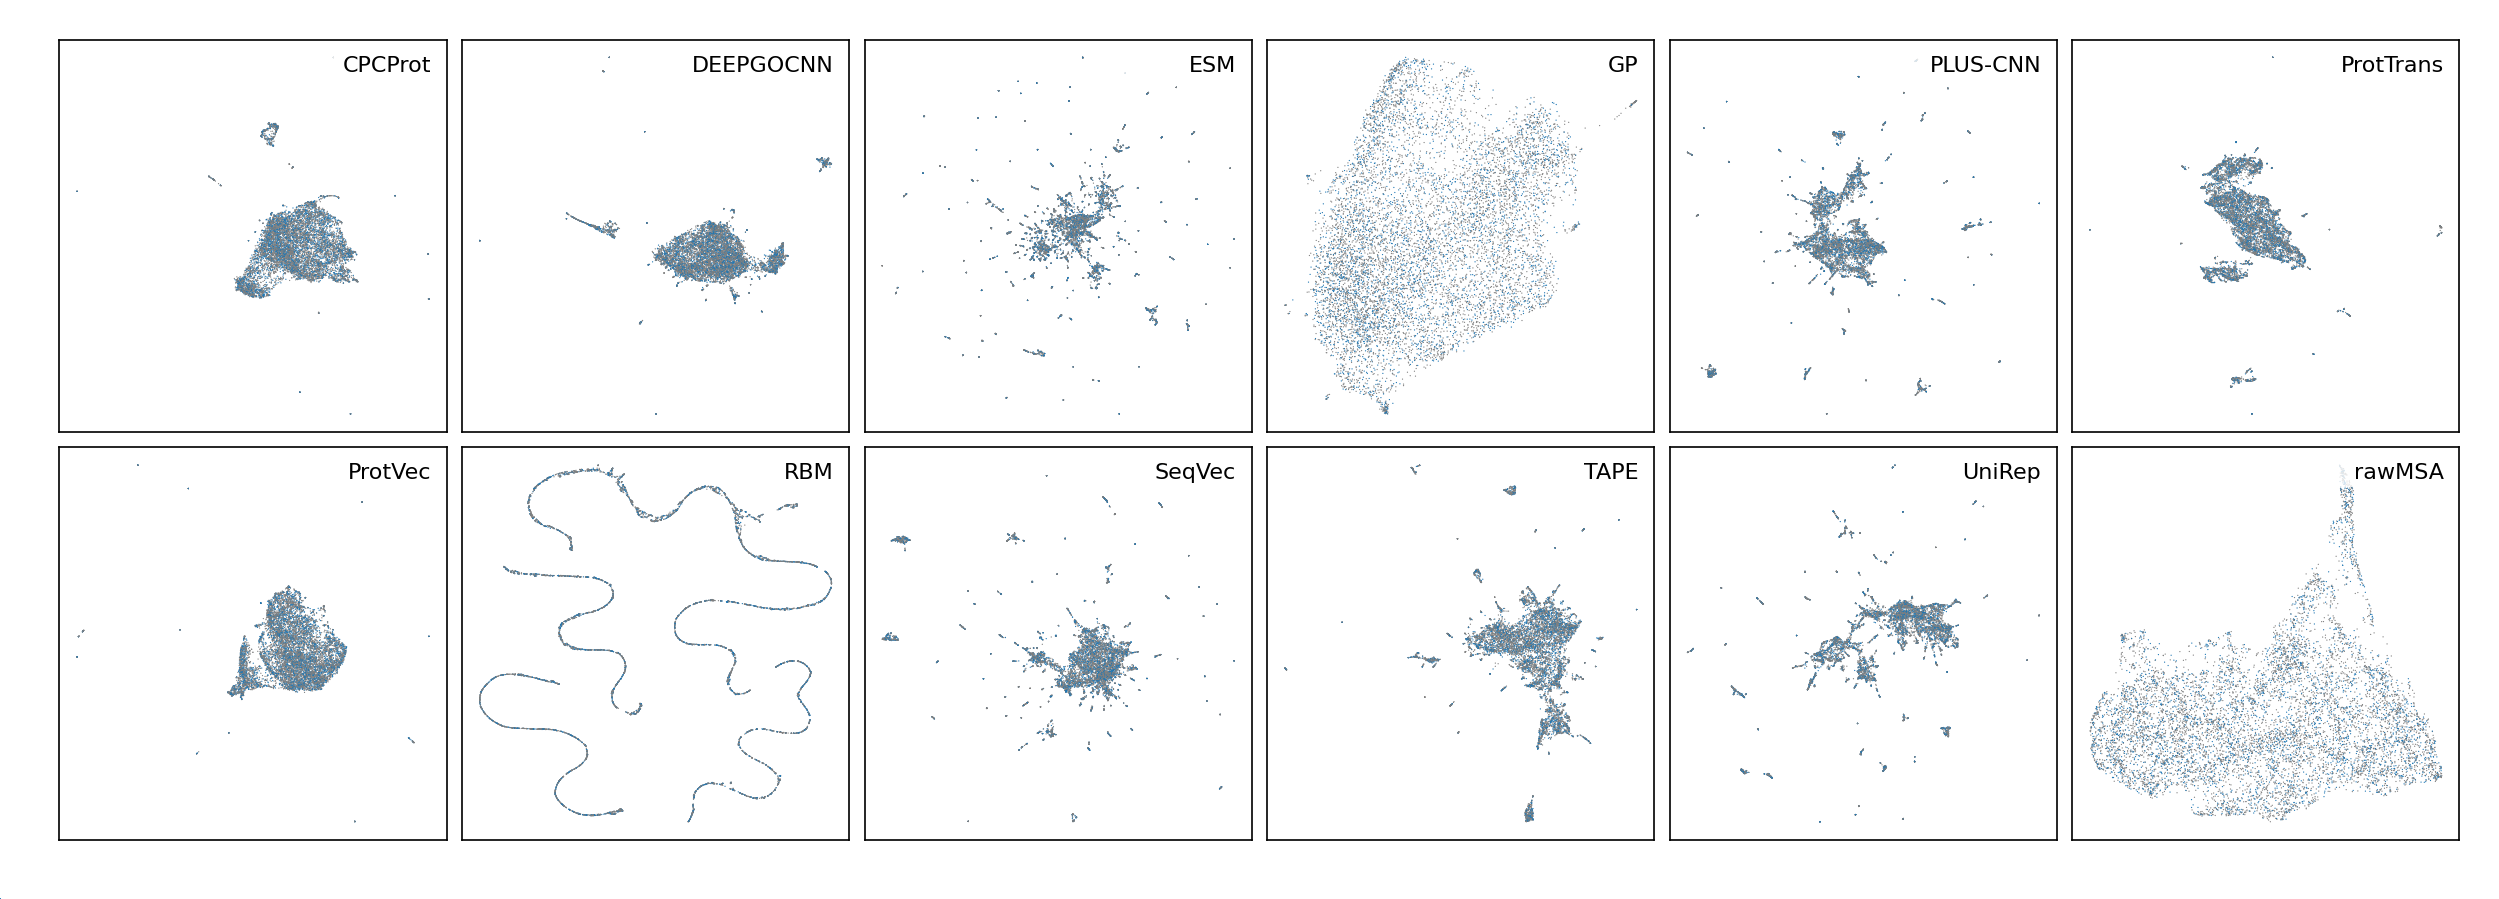

In [4]:
#@title Visualize projections with a given PFAM domain { run: "auto" }
#@markdown Select PFAM domain to be highlighted.

pfam_domain = 'pfam999' #@param ["pfam6992", "pfam999", "foo"]

# Define color mappings
emb = list(projs.values())[0]
nembs = emb.shape[0]

# fake domains
p2d = {}
for i in range(nembs):
  rn = np.random.randint(3)
  if rn == 1:
    domain = 'pfam6992'
  elif rn == 2:
    domain = 'pfam999'
  else: 
    domain = 'foo'

  p2d[i] = domain

domain2color = {
    "pfam6992": 'tab:orange', 
    "pfam999":'tab:blue', 
    'foo':'black'
}


# highlight embeddings containing input domain
colors = []

for i in range(nembs):
  color = domain2color[pfam_domain] if p2d[i] == pfam_domain else 'gray'
  colors.append(color)

plt.rcParams.update({'font.size': 4})
fig, axs = plt.subplots(2, 6, figsize=(6,2), dpi=400, linewidth=.1)
plt.subplots_adjust(left=0,
                    right=1,
                    bottom=0,
                    top=1,
                    wspace=.04, 
                    hspace=.04)

keys = list(projs.keys())
k = 0
nrows = 2
ncols = 6
for i in range(nrows):
  for j in range(ncols):
    pname = keys[k]
    proj = projs[keys[k]]
    axs[i][j].scatter(proj[:,0], 
                      proj[:,1], 
                      s=.05, 
                      c=colors, 
                      edgecolor='none',
                      label=pname)
    #axs[i][j].axis('off')
    axs[i][j].xaxis.set_ticklabels([])
    axs[i][j].yaxis.set_ticklabels([])
    axs[i][j].set_xticks([])
    axs[i][j].set_yticks([])

    axs[i][j].spines['bottom'].set_linewidth(.3)
    axs[i][j].spines['left'].set_linewidth(.3)
    axs[i][j].spines['top'].set_linewidth(.3)
    axs[i][j].spines['right'].set_linewidth(.3)

    axs[i][j].legend(loc="upper right", 
                     scatterpoints=0,
                     borderpad=0.2, 
                     edgecolor='none')
    
    k += 1

#plt.savefig('premb_projs.pdf', 
#            dpi=300, 
#            bbox_inches='tight', 
#            pad_inches = 0.02) 
plt.show()